<a href="https://colab.research.google.com/github/MeenaRuwandi/INCS_870_Project_IDSforMinorAttacks/blob/meena/incs870_team4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install imbalanced-learn
!pip install scikit-learn

In [16]:
!pip install gdown
import gdown

In [17]:
# Required Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [18]:
file_ids = [
    '1zOeCqtGZjAj_nSLe3W5MH5pDQM28bPde',  # Replace with actual file ID
    '1fagr2rKW8EN-Psc5UlD9BFfa0rRRF6i3',  # Replace with actual file ID
    '1WL00LFkCA2ylV8_8c6jm52bnEhGLcKsq',   # Replace with actual file ID
    '1xr_QBU3Ab42nW1ELl0NUydx4Rbx60TVR',
    '1MpqHsC5wQSu9CxlhJimz25EVcYubSMhu',
    '18mKfJHXinmfwPpaYNU2D6xHwq4dQuEuL',
    '1h1lMHytamf4Kc66NfAfMfBzDbmwM5Ub5',
    '11__JhC64_D4ezxjF8d0dPNRDJF-TY6Pq'
]


# Download each file
for i, file_id in enumerate(file_ids):
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, f'dataset_{i + 1}.csv', quiet=False)  # Saves as dataset_1.csv, dataset_2.csv, etc.

Downloading...
From (original): https://drive.google.com/uc?id=1zOeCqtGZjAj_nSLe3W5MH5pDQM28bPde
From (redirected): https://drive.google.com/uc?id=1zOeCqtGZjAj_nSLe3W5MH5pDQM28bPde&confirm=t&uuid=090bd13e-9f78-4870-903e-d7b195d2f496
To: /content/dataset_1.csv
100%|██████████| 225M/225M [00:00<00:00, 304MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1fagr2rKW8EN-Psc5UlD9BFfa0rRRF6i3
From (redirected): https://drive.google.com/uc?id=1fagr2rKW8EN-Psc5UlD9BFfa0rRRF6i3&confirm=t&uuid=a53de6cb-fc0d-4e65-8bc4-944d1771cc00
To: /content/dataset_2.csv
100%|██████████| 135M/135M [00:01<00:00, 71.9MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1WL00LFkCA2ylV8_8c6jm52bnEhGLcKsq
From (redirected): https://drive.google.com/uc?id=1WL00LFkCA2ylV8_8c6jm52bnEhGLcKsq&confirm=t&uuid=8edd16e8-b603-415c-8e15-29d15b2bfa4c
To: /content/dataset_3.csv
100%|██████████| 52.0M/52.0M [00:00<00:00, 203MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xr_QBU3Ab42nW1

In [19]:
dataset_paths = [
    '/content/dataset_1.csv','/content/dataset_2.csv','/content/dataset_3.csv','/content/dataset_4.csv',
    '/content/dataset_5.csv','/content/dataset_6.csv','/content/dataset_7.csv','/content/dataset_8.csv',
]

# Make the data frame
dataframes = [pd.read_csv(path) for path in dataset_paths]

# Combine all datasets into one dataframe
combined_dataset = pd.concat(dataframes, ignore_index=True)

In [20]:
combined_dataset.describe()

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,...,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06
mean,8.071483e+03,1.478566e+07,9.361160e+00,1.039377e+01,5.493024e+02,1.616264e+04,2.075999e+02,1.871366e+01,5.820194e+01,6.891013e+01,...,5.418218e+00,-2.741688e+03,8.155132e+04,4.113412e+04,1.531825e+05,5.829582e+04,8.316037e+06,5.038439e+05,8.695752e+06,7.920031e+06
std,1.828363e+04,3.365374e+07,7.496728e+02,9.973883e+02,9.993589e+03,2.263088e+06,7.171848e+02,6.033935e+01,1.860912e+02,2.811871e+02,...,6.364257e+02,1.084989e+06,6.485999e+05,3.933815e+05,1.025825e+06,5.770923e+05,2.363008e+07,4.602984e+06,2.436689e+07,2.336342e+07
min,0.000000e+00,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.300000e+01,1.550000e+02,2.000000e+00,1.000000e+00,1.200000e+01,0.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,3.131600e+04,2.000000e+00,2.000000e+00,6.200000e+01,1.230000e+02,3.700000e+01,2.000000e+00,3.400000e+01,0.000000e+00,...,1.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,3.204828e+06,5.000000e+00,4.000000e+00,1.870000e+02,4.820000e+02,8.100000e+01,3.600000e+01,5.000000e+01,2.616295e+01,...,2.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553500e+04,1.200000e+08,2.197590e+05,2.919220e+05,1.290000e+07,6.554530e+08,2.482000e+04,2.325000e+03,5.940857e+03,7.125597e+03,...,2.135570e+05,1.380000e+02,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


In [21]:
combined_dataset.shape

(2830743, 79)

In [22]:
combined_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

In [23]:
# Pre processing
x = combined_dataset.drop(columns=[' Label'])
y = combined_dataset[' Label']
# Handle missing values
x.fillna(x.mean(), inplace=True)

# Get 'Label' column that indicates attack types
class_distribution = combined_dataset[' Label'].value_counts()
print(class_distribution)

 Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


In [24]:
#check for missing values
missing_values=combined_dataset.isnull().sum()
print("missing values in each column :\n", missing_values[missing_values>0])

missing values in each column :
 Flow Bytes/s    1358
dtype: int64


In [25]:
combined_dataset.columns = combined_dataset.columns.str.strip()
print(combined_dataset.columns.tolist())


#fill missing values with the mean value of 'Flow Bytes/s' column with its mean value
meanVal = combined_dataset['Flow Bytes/s'].mean()

#verify if all the missing values are handled
combined_dataset['Flow Bytes/s'].fillna(meanVal, inplace=True)
missingValCheck = combined_dataset.isnull().sum()

#print("missing values after handling : \n", missingValCheck[missingValCheck>0])
print("Missing values after handling:\n", missingValCheck[missingValCheck > 0])




['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count

In [26]:
print(combined_dataset.columns.tolist())

print(combined_dataset['Flow Bytes/s'].dtype)



['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count

In [27]:
#separating features as X and target variable as Y
X= combined_dataset.drop(columns=['Label'])
Y= combined_dataset['Label']
#print the shape of X and Y
print("features shape",X.shape)
print("Target variable shape", Y.shape)

features shape (2830743, 78)
Target variable shape (2830743,)


In [29]:
import numpy as np

#check for infinity values
infVal=X.isin([np.inf, -np.inf]).sum()
print("Infinity values in each column:\n", infVal[infVal>0])

# Check for excessively large values (based on what you deem large)
large_values = X.apply(lambda x: x > 1e6).sum()
print("Large values in each column: \n", large_values[large_values > 0])

Infinity values in each column:
 Flow Bytes/s      2867
Flow Packets/s    2867
dtype: int64
Large values in each column: 
 Flow Duration                  787703
Total Length of Fwd Packets        33
Total Length of Bwd Packets      1908
Flow Bytes/s                   412675
Flow Packets/s                  34283
Flow IAT Mean                  548718
Flow IAT Std                   684261
Flow IAT Max                   766252
Flow IAT Min                    18045
Fwd IAT Total                  719864
Fwd IAT Mean                   582650
Fwd IAT Std                    610547
Fwd IAT Max                    698294
Fwd IAT Min                     66140
Bwd IAT Total                  462365
Bwd IAT Mean                   357584
Bwd IAT Std                    344940
Bwd IAT Max                    450344
Bwd IAT Min                     62420
Fwd Header Length                  52
Bwd Header Length                  54
Fwd Packets/s                   29050
Bwd Packets/s                     132
Pac

In [30]:
#To Handle infinity values : Replace infinity values with
X.replace([np.inf,-np.inf],np.nan,inplace=True)

#To Handle Large values : Capping extremely large values
X = X.apply(lambda x: np.where(x > 1e6, 1e6, x))  # Example threshold 1e6

# Fill missing values after replacing infinity
X.fillna(X.mean(), inplace=True)

# Check for any remaining missing values
print(X.isnull().sum())



Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
                              ..
Active Min                     0
Idle Mean                      0
Idle Std                       0
Idle Max                       0
Idle Min                       0
Length: 78, dtype: int64


In [31]:
#selecting best features for the training model out of 78 features
#use Random forest algorithm
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

#Train a model with Random Forest
rfModel=RandomForestClassifier(n_estimators=100, random_state=42)
rfModel.fit(X,Y)

#Get important feature
importantFeatures=rfModel.feature_importances_

                        Feature  Importance
41            Packet Length Std    0.057404
54         Avg Bwd Segment Size    0.053411
39            Max Packet Length    0.050424
42       Packet Length Variance    0.047645
63            Subflow Fwd Bytes    0.044556
0              Destination Port    0.044273
52          Average Packet Size    0.038268
10        Bwd Packet Length Max    0.037486
12       Bwd Packet Length Mean    0.035119
4   Total Length of Fwd Packets    0.033908
6         Fwd Packet Length Max    0.032731
5   Total Length of Bwd Packets    0.032375
13        Bwd Packet Length Std    0.031699
66       Init_Win_bytes_forward    0.031648
40           Packet Length Mean    0.031502
65            Subflow Bwd Bytes    0.028601
53         Avg Fwd Segment Size    0.022895
37                Bwd Packets/s    0.018357
8        Fwd Packet Length Mean    0.016926
46               PSH Flag Count    0.016024


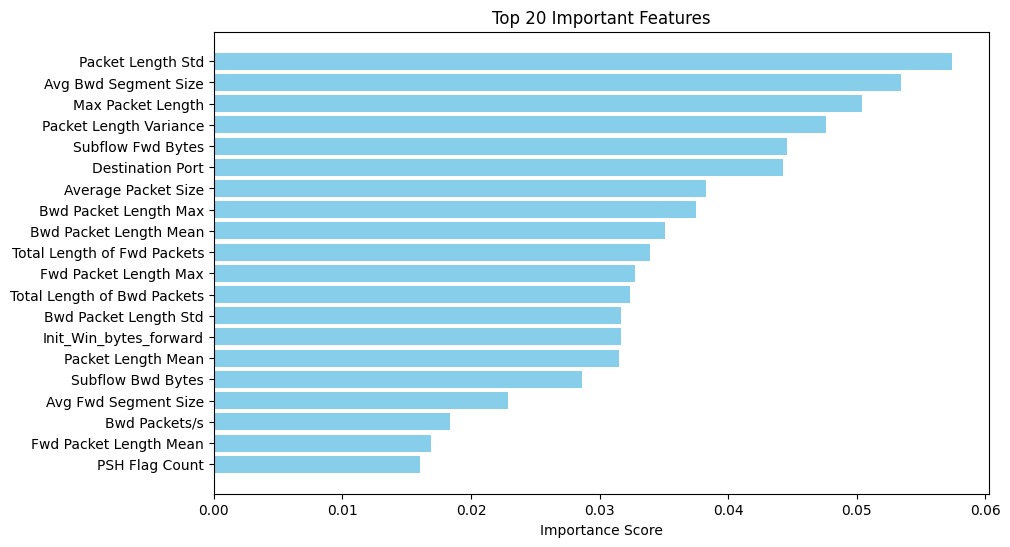

In [33]:
#Creating another Data frame with selected most importand features and their importance factor
importantFeatures_df=pd.DataFrame({
    'Feature' : X.columns,
    'Importance': importantFeatures
})

#Sort the Dataframe by importance scores in decending order
importantFeatures_df = importantFeatures_df.sort_values(by='Importance', ascending=False)

# Display the top important features
print(importantFeatures_df.head(20))  # Change 10 to the number of features you want to display

# Plotting feature importances
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.barh(importantFeatures_df['Feature'][:20], importantFeatures_df['Importance'][:20], color='skyblue')  # Change to top 20
plt.xlabel('Importance Score')
plt.title('Top 20 Important Features')  # Update title to reflect the change
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


In [34]:
importantFeatures_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78 entries, 41 to 61
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Feature     78 non-null     object 
 1   Importance  78 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.8+ KB


In [35]:
# Assuming 'top_features' contains the names of the 20 important features
top_features = importantFeatures_df.nlargest(20, 'Importance')['Feature']

# Create a new DataFrame with selected features and the target variable
selected_features_df = combined_dataset[top_features.values.tolist() + ['Label']]

# Display the new DataFrame to verify
print(selected_features_df.head())


   Packet Length Std  Avg Bwd Segment Size  Max Packet Length  \
0           0.000000              6.000000                  6   
1          56.529599             65.200000                163   
2         671.751541            525.000000               1575   
3         704.654082            555.000000               3069   
4         704.585067            525.333333               1576   

   Packet Length Variance  Subflow Fwd Bytes  Destination Port  \
0                0.000000                  6                80   
1             3195.595588                172               389   
2           451250.132400               3150                88   
3           496537.374700               3452               389   
4           496440.116700               3150                88   

   Average Packet Size  Bwd Packet Length Max  Bwd Packet Length Mean  \
0             9.000000                      6                6.000000   
1            31.125000                    163               65.200

In [36]:
selected_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 21 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Packet Length Std            float64
 1   Avg Bwd Segment Size         float64
 2   Max Packet Length            int64  
 3   Packet Length Variance       float64
 4   Subflow Fwd Bytes            int64  
 5   Destination Port             int64  
 6   Average Packet Size          float64
 7   Bwd Packet Length Max        int64  
 8   Bwd Packet Length Mean       float64
 9   Total Length of Fwd Packets  int64  
 10  Fwd Packet Length Max        int64  
 11  Total Length of Bwd Packets  int64  
 12  Bwd Packet Length Std        float64
 13  Init_Win_bytes_forward       int64  
 14  Packet Length Mean           float64
 15  Subflow Bwd Bytes            int64  
 16  Avg Fwd Segment Size         float64
 17  Bwd Packets/s                float64
 18  Fwd Packet Length Mean       float64
 19  

In [39]:
from sklearn.preprocessing import LabelEncoder

#initiate the lable encoder
labelEncoder=LabelEncoder()

#fit the encoder to the lable data
y_encode=labelEncoder.fit_transform(Y)

#check the data type
y_encode.dtype

dtype('int64')

In [41]:
from sklearn.model_selection import train_test_split

#Use features from selected_features_df dataframe and y_encode
x_train,x_test,y_train,y_test=train_test_split(selected_features_df,y_encode,test_size=0.2,random_state=42,stratify=y_encode)

#check the shapes of the resulting datsets
print("Traning features set shape:",x_train.shape)
print("Test features set shape:",x_test.shape)
print("Traning Lable set shape:",y_train.shape)
print("Test Lable set shape:",y_test.shape)

Traning features set shape: (2264594, 21)
Test features set shape: (566149, 21)
Traning Lable set shape: (2264594,)
Test Lable set shape: (566149,)
